In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [68]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [69]:
train = train.set_index('row_id')
test = test.set_index('row_id')

In [70]:
train.head(10)

,time,x,y,direction,congestion
row_id,,,,,
0,1991-04-01 00:00:00,0,0,EB,70
1,1991-04-01 00:00:00,0,0,NB,49
2,1991-04-01 00:00:00,0,0,SB,24
3,1991-04-01 00:00:00,0,1,EB,18
4,1991-04-01 00:00:00,0,1,NB,60
5,1991-04-01 00:00:00,0,1,SB,58
6,1991-04-01 00:00:00,0,1,WB,26
7,1991-04-01 00:00:00,0,2,EB,31
8,1991-04-01 00:00:00,0,2,NB,49


In [71]:
# lot of informtion is packed in time column lets unpack it
def split_data(df,split_list, col_name, split_char):
    x = 0
    for element in split_list:
        df[element] = df[col_name].str.split(split_char, expand=True)[x]
        x = x + 1

In [72]:
split_data(train, ['date', 'time'], 'time', ' ')
split_data(train, ['year','month','day'], 'date', '-')
split_data(train, ['hours','minutes','seconds'],'time',':')

In [73]:
# changing date format
train['date'] = pd.to_datetime(train['date'])
train['week_day'] = train['date'].dt.day_name()

In [74]:
#  droping unneccesary columns
train = train.drop(['time','date', 'year', 'seconds'], axis = 1)

In [75]:
# reindexing column positions
train = train[['month','week_day','day', 'hours', 'minutes', 'x','y','direction', 'congestion']]

In [76]:
# unique elements in dataframe
for col in train.columns:
    print(col)
    print(train[col].unique())

month
['04' '05' '06' '07' '08' '09']
week_day
['Monday' 'Tuesday' 'Wednesday' 'Thursday' 'Friday' 'Saturday' 'Sunday']
day
['01' '02' '03' '04' '05' '06' '07' '08' '09' '10' '11' '12' '13' '14'
 '15' '16' '17' '18' '19' '20' '21' '22' '23' '24' '25' '26' '27' '28'
 '29' '30' '31']
hours
['00' '01' '02' '03' '04' '05' '06' '07' '08' '09' '10' '11' '12' '13'
 '14' '15' '16' '17' '18' '19' '20' '21' '22' '23']
minutes
['00' '20' '40']
x
[0 1 2]
y
[0 1 2 3]
direction
['EB' 'NB' 'SB' 'WB' 'NE' 'SW' 'NW' 'SE']
congestion
[ 70  49  24  18  60  58  26  31  46  29  16  21  47  51  74  43  44  52
  32  77  39  63  53  28  54  41  37  15  61  65  22  34  45  42  50  36
  64  30  55  57  40  33  17  48  71  69  10  67  80  91  35  56  59  38
  78  27  79  20  83  62  25  19   7  82  75  76  85 100   2  88  12  89
  73  11  81  72  13  84  23  92  14   6   8   9  66  68   5   0  95  87
  90  97  86  96  94   4  93   3   1  98  99]


<BarContainer object of 101 artists>

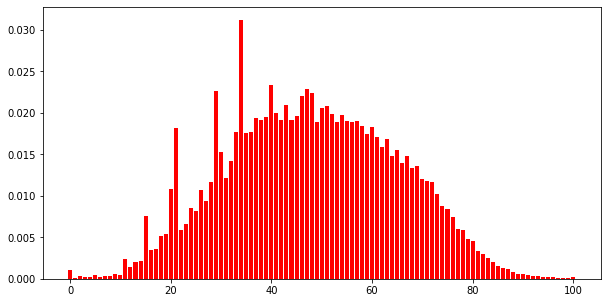

In [77]:
# proportions of target variables
cong = train['congestion'].value_counts()/len(train)
plt.figure(figsize = (10,5))
plt.bar(cong.index, cong, color = 'red')

In [78]:
# splitting the dataset in training and cross -validation dataset
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=1200)
for train_index, cv_index in split.split(train, train['congestion']):
    train_ = train.loc[train_index]
    cv = train.loc[cv_index]

In [79]:
# encoding the variables
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
x_train = enc.fit_transform(train_.iloc[:, :-1]).toarray()
y_train = train_.iloc[:,-1]

In [80]:
x_cv = enc.transform(cv.iloc[:,:-1]).toarray()
y_cv = cv.iloc[:,-1]

In [81]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

In [15]:
params = { 'max_depth':[3,4,5,6],
           'learning_rate':[0.01, 0.1, 0.2]}


In [16]:
# best parameter search
grid_search = GridSearchCV( estimator= xgb.XGBRegressor(objective ='reg:squarederror',
                                                      seed = 12,
                                                      subsample=0.5,
                                                      colsample_bytree=0.5),
                           param_grid = params,
                           scoring = 'neg_mean_squared_error',
                           verbose=3,
                           cv=3)

In [22]:
grid_search.fit(x_train,y_train)

NameError: name 'grid_search' is not defined

In [18]:
grid_search.best_params_

{'learning_rate': 0.2, 'max_depth': 6}

In [82]:
# making test data consistent in structure with train data
split_data(test, ['date', 'time'], 'time', ' ')
split_data(test, ['year','month','day'], 'date', '-')
split_data(test, ['hours','minutes','seconds'],'time',':')

In [83]:
test['date'] = pd.to_datetime(test['date'])
test['week_day'] = test['date'].dt.day_name()
test = test.drop(['time','date', 'year', 'seconds'], axis = 1)
test = test[['month','week_day','day', 'hours', 'minutes', 'x','y','direction']]
index = test.index

In [84]:
test = enc.transform(test).toarray()

In [85]:
# setting xgboost parameters
xgbreg = xgb.XGBRegressor(objective='reg:squarederror',
                          learning_rate=0.2,
                          max_depth=6,
                          reg_lambda = 1.0,
                          subsample = 0.5,
                          seed=12)

In [86]:
# fitting data in xgboost 
xgbreg.fit(x_train,y_train,
                   early_stopping_rounds=5,
                   eval_metric='rmse',
                   eval_set=[(x_cv,y_cv)])

[0]	validation_0-rmse:41.02385
[1]	validation_0-rmse:33.81119
[2]	validation_0-rmse:28.12892
[3]	validation_0-rmse:23.78673
[4]	validation_0-rmse:20.55464
[5]	validation_0-rmse:18.16320
[6]	validation_0-rmse:16.43446
[7]	validation_0-rmse:15.19395
[8]	validation_0-rmse:14.25936
[9]	validation_0-rmse:13.61901
[10]	validation_0-rmse:13.19407
[11]	validation_0-rmse:12.56710
[12]	validation_0-rmse:12.33723
[13]	validation_0-rmse:12.07307
[14]	validation_0-rmse:11.94540
[15]	validation_0-rmse:11.76927
[16]	validation_0-rmse:11.68558
[17]	validation_0-rmse:11.61985
[18]	validation_0-rmse:11.55593
[19]	validation_0-rmse:11.49165
[20]	validation_0-rmse:11.43037
[21]	validation_0-rmse:11.32436
[22]	validation_0-rmse:11.29276
[23]	validation_0-rmse:11.25154
[24]	validation_0-rmse:11.21744
[25]	validation_0-rmse:11.17436
[26]	validation_0-rmse:11.13818
[27]	validation_0-rmse:11.09759
[28]	validation_0-rmse:11.07302
[29]	validation_0-rmse:11.04881
[30]	validation_0-rmse:11.03170
[31]	validation_0-

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.2, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=12,
             reg_alpha=0, reg_lambda=1.0, scale_pos_weight=1, seed=12,
             subsample=0.5, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [87]:
x = enc.transform(train.iloc[:,:-1]).toarray()
y = train.iloc[:,-1]
model = xgbreg.fit(x,y)

In [88]:
# making predictions for test data
y_pred = model.predict(test)

In [89]:
# saving the predictions
prediction = pd.DataFrame({'row_id': index,
                          'congestion': y_pred})

In [90]:
# saving the file
prediction.to_csv('submission.csv', index=False)